In [43]:
import pandas as pd 
import os
from utils.explanations import minmax_norm
from utils.utils import read_dataset
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from utils.explanations import calculate_cam_attributions
import matplotlib.pyplot as plt

data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'GunPoint'
data_source = 'original'
ylen = 1
data = read_dataset(data_p, archive, dataset_name,  data_source, ylen)[dataset_name]
data_source = 'fcn_raw'
ylen = len(data[0][0])


def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                            + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                            + f'best_model.hdf5'
    model =keras.models.load_model(model_path ,compile=False)
    return model


root_dir ='G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
classifier = 'fcn_1.0'
data_source = 'original'
dataset_name = 'GunPoint'

x,y,_,_ =data

model = load_model(root_dir, archive_name, dataset_name, classifier, data_source)

model(x)
y = y-1

In [54]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas

In [55]:
%matplotlib inline
import tensorflow as tf 
def interpolate_series(baseline,
                       series,
                       alphas):
  alphas_x = alphas[:,tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(series, axis=0)
  delta = tf.expand_dims((series - baseline),axis=0)
  series = baseline_x +  alphas_x * delta
  return series

def compute_gradients(series):
  with tf.GradientTape() as tape:
    tape.watch(series)
    logits = model(series)
  return tape.gradient(logits, series)

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

@tf.function
def integrated_gradients(baseline,
                         series,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_series(baseline=baseline,
                                                       series=series,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(series=interpolated_path_input_batch
                                       )

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (series - baseline) * avg_gradients

  return integrated_gradients

ts = 30


avg = np.average(x, axis=0)
avg = tf.convert_to_tensor(avg, dtype = np.float32)

baseline = avg#tf.zeros(len(x[0]))#avg#tf.zeros(150)
series = x[ts]

ig_att =integrated_gradients(baseline,series.astype('float32'))

idx = 0

cam_att = calculate_cam_attributions(root_dir, archive_name, classifier, dataset_name, data_source)[idx]
cam_att = cam_att[ts][1]

ig_vis = prepare_visualize_attribution(x[ts],ig_att)
cam_vis = prepare_visualize_attribution(x[ts],cam_att)

#print(np.corrcoef(value,cam_att))

fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
ax[0].scatter(cam_vis[0],cam_vis[1],c=cam_vis[2], cmap='jet')
ax[1].scatter(ig_vis[0],ig_vis[1],c=ig_vis[2], cmap='jet')
plt.tight_layout()

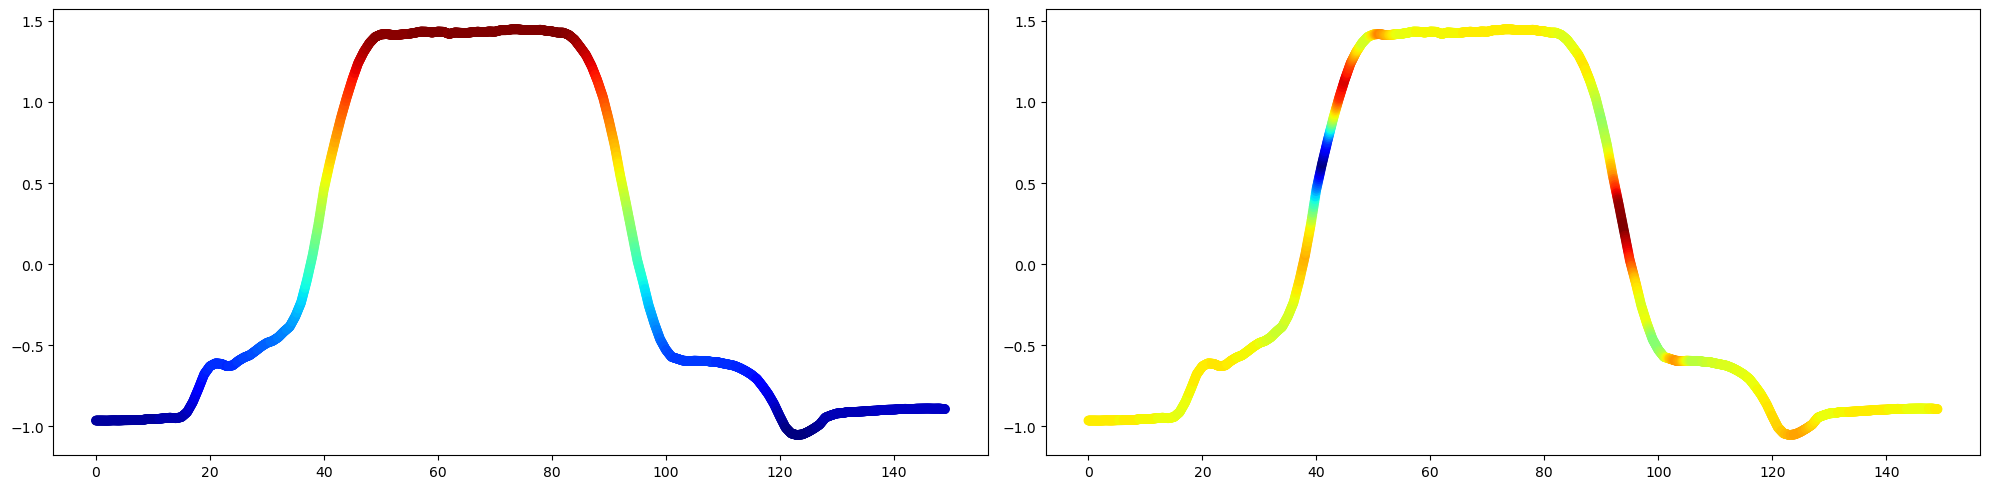

In [53]:
print(cam_att)

[-0.96433  -0.96426  -0.96477  -0.96309  -0.96376  -0.96239  -0.962
 -0.96154  -0.96097  -0.95563  -0.95475  -0.95381  -0.94986  -0.94671
 -0.95005  -0.9431   -0.91262  -0.8506   -0.76758  -0.67859  -0.62965
 -0.61139  -0.61473  -0.62927  -0.62442  -0.59615  -0.57529  -0.56127
 -0.53517  -0.50789  -0.48563  -0.4736   -0.45091  -0.41557  -0.38558
 -0.32147  -0.2364   -0.10262   0.05185   0.23966   0.46068   0.62007
  0.76559   0.90351   1.0267    1.1392    1.2382    1.3085    1.3628
  1.4004    1.416     1.4184    1.4134    1.4135    1.4175    1.4203
  1.4264    1.4337    1.4329    1.4278    1.4338    1.4325    1.419
  1.4285    1.4263    1.425     1.4297    1.4332    1.4302    1.4345
  1.4328    1.4421    1.4423    1.4477    1.4479    1.4439    1.4439
  1.443     1.4451    1.4387    1.4352    1.4276    1.4273    1.4128
  1.3831    1.3373    1.2889    1.2196    1.1309    1.0266    0.88836
  0.73476   0.54673   0.37844   0.20131   0.023965 -0.11019  -0.25447
 -0.36629  -0.46337  -0.52737

array([-0.64443 , -0.6454  , -0.64706 , -0.64749 , -0.64691 , -0.64388 ,
       -0.63973 , -0.63809 , -0.6353  , -0.63538 , -0.63411 , -0.63372 ,
       -0.63205 , -0.63228 , -0.62956 , -0.6287  , -0.62747 , -0.62409 ,
       -0.62038 , -0.61557 , -0.61236 , -0.60895 , -0.60814 , -0.60875 ,
       -0.60932 , -0.60964 , -0.61068 , -0.61113 , -0.61108 , -0.61171 ,
       -0.61088 , -0.60945 , -0.60894 , -0.60689 , -0.60496 , -0.60258 ,
       -0.60001 , -0.59801 , -0.59754 , -0.59777 , -0.59699 , -0.59715 ,
       -0.59554 , -0.59359 , -0.59578 , -0.59911 , -0.59121 , -0.56584 ,
       -0.50726 , -0.47291 , -0.39633 , -0.33415 , -0.2     , -0.084494,
        0.10084 ,  0.31489 ,  0.52512 ,  0.69455 ,  0.80781 ,  0.92774 ,
        1.0859  ,  1.2465  ,  1.4187  ,  1.5884  ,  1.7182  ,  1.8249  ,
        1.8472  ,  1.8518  ,  1.8724  ,  1.8872  ,  1.8986  ,  1.9094  ,
        1.9125  ,  1.9097  ,  1.9175  ,  1.919   ,  1.919   ,  1.9252  ,
        1.9172  ,  1.92    ,  1.9212  ,  1.9229  , 